<a href="https://colab.research.google.com/github/Taejin1221/MachineLearning/blob/master/TrajectoryAugmentation/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

np.random.seed( 25 )
tf.executing_eagerly()

False

# Data Preprocessing

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train = X_train / 255.
X_test = X_test / 255.

In [4]:
print( X_train.shape )
print( X_test.shape )

(60000, 28, 28)
(10000, 28, 28)


In [5]:
X_train_new = X_train.reshape( X_train.shape[0], 28, 28, 1 )
X_test_new = X_test.reshape( X_test.shape[0], 28, 28, 1 )

In [6]:
print( X_train_new.shape )
print( X_test_new.shape )

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Construct Encoder Part

In [7]:
SIZE = 28

latent_dim = 2

In [8]:
encoder_input = layers.Input( shape = ( SIZE, SIZE, 1 ) )
encoder_conv = layers.Conv2D( 8, 3, 2, 'same', activation = 'relu' )( encoder_input )
# encoder_conv = layers.Conv2D( 16, 3, 2, 'same', activation = 'relu' )( encoder_input )
encoder_conv = layers.Conv2D( 16, 3, 2, 'same', activation = 'relu' )( encoder_conv )

encoder = layers.Flatten()( encoder_conv )

mu = layers.Dense( latent_dim )( encoder )
sigma = layers.Dense( latent_dim )( encoder )

In [9]:
def ComputeLatent( x ):
    mu, sigma = x
    batch = K.shape( mu )[0]
    dim = K.int_shape( mu )[1]
    eps = K.random_normal( shape = ( batch, dim ) )

    return mu + K.exp( sigma / 2 ) * eps

In [10]:
latent_space = layers.Lambda( ComputeLatent, output_shape = ( latent_dim, ) )( [ mu, sigma ])

In [11]:
conv_shape = K.int_shape( encoder_conv )
conv_shape

(None, 7, 7, 16)

# Construct Decoder Part

In [12]:
decoder_input = layers.Input( shape = ( latent_dim, ) )

units = conv_shape[1] * conv_shape[2] * conv_shape[3]
decoder = layers.Dense( units, 'relu' )( decoder_input )
decoder = layers.Reshape( ( conv_shape[1], conv_shape[2], conv_shape[3] ) )( decoder )

decoder_conv = layers.Conv2DTranspose( 16, 3, 2, 'same', activation = 'relu' )( decoder )
# decoder_conv = layers.Conv2DTranspose( 8, 3, 2, 'same', activation = 'relu' )( decoder )
decoder_conv = layers.Conv2DTranspose( 8, 3, 2, 'same', activation = 'relu' )( decoder_conv )
decoder_conv = layers.Conv2DTranspose( 1, 3, padding = 'same', activation = 'sigmoid' )( decoder_conv )

# Connect Encoder and Decoder

In [13]:
encoder = keras.models.Model( encoder_input, latent_space, name = 'Encoder' )
decoder = keras.models.Model( decoder_input, decoder_conv, name = 'Decoder' )

In [14]:
vae = keras.models.Model( encoder_input, decoder( encoder( encoder_input ) ), name = 'VAE' )

In [15]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 16)     1168        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [16]:
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 8)         1160      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         73        
Total params: 5,905
Trainable params: 5,905
Non-trainable params: 0
_________________________________________________________

In [17]:
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoder (Functional)         (None, 2)                 4388      
_________________________________________________________________
Decoder (Functional)         (None, 28, 28, 1)         5905      
Total params: 10,293
Trainable params: 10,293
Non-trainable params: 0
_________________________________________________________________


# Define loss function and compile model

In [18]:
def KL_Reconstruction_Loss( true, pred ):
    reconstruction_loss = keras.losses.binary_crossentropy( K.flatten( true ), K.flatten( pred ) ) * SIZE * SIZE

    kl_loss = 1 + sigma - K.square( mu ) - K.exp( sigma )
    kl_loss = K.sum( kl_loss, axis = -1 )
    kl_loss *= -0.5

    return K.mean( reconstruction_loss + kl_loss )

In [19]:
vae.compile( 'adam', KL_Reconstruction_Loss )

# Train Model

In [20]:
BATCH_SIZE = 32
EPOCHS = 20

In [21]:

history = vae.fit( X_train_new, X_train_new, BATCH_SIZE, EPOCHS, validation_data = ( X_test_new, X_test_new ) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59968/60000 [============================>.] - ETA: 0s - loss: 198.1505WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
60000/60000 [==============================] - 8s 138us/sample - loss: 198.1391 - val_loss: 175.3482
Epoch 2/20
60000/60000 [==============================] - 8s 140us/sample - loss: 171.7113 - val_loss: 167.7646
Epoch 3/20
60000/60000 [==============================] - 9s 148us/sample - loss: 166.5374 - val_loss: 165.0154
Epoch 4/20
60000/60000 [==============================] - 8s 136us/sample - loss: 164.4799 - val_loss: 163.0508
Epoch 5/20
60000/60000 [==============================] - 8s 137us/sample - l

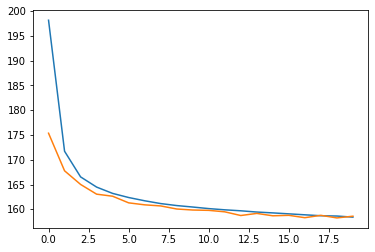

In [22]:
plt.plot( history.history['loss'] )
plt.plot( history.history['val_loss'] )

# Display Latent Space

In [23]:
encoded = encoder.predict( X_train_new )

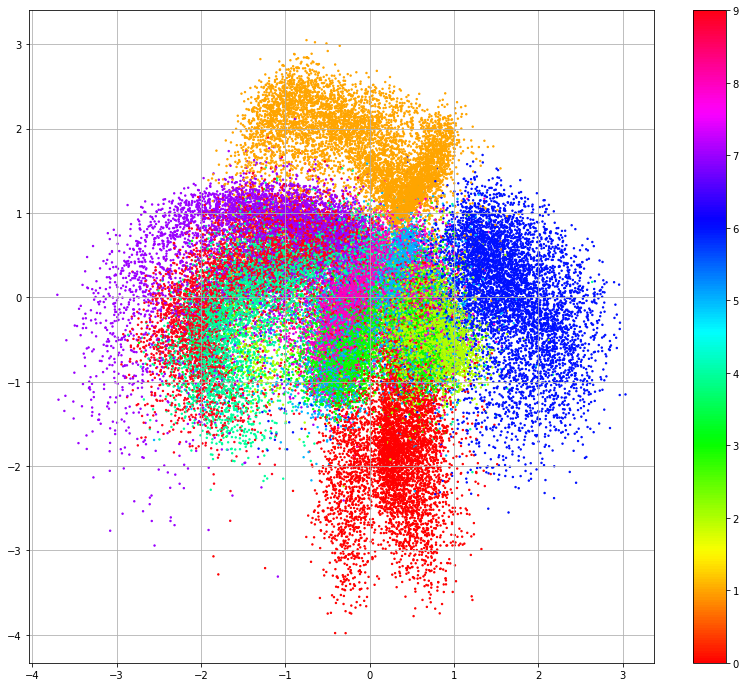

In [24]:
plt.figure( figsize = ( 14, 12 ) )
plt.scatter( encoded[:, 0], encoded[:, 1], s = 2, c = y_train, cmap = 'hsv' )
plt.colorbar()
plt.grid()
plt.show()

In [25]:
def display_image_sequence( x_start, y_start, x_end, y_end, num_imgs ):
    x_axis = np.linspace( x_start, x_end, num_imgs )
    y_axis = np.linspace( y_start, y_end, num_imgs )

    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]

    new_points = np.hstack( ( x_axis, y_axis ) )
    new_images = decoder.predict( new_points )
    new_images = new_images.reshape( new_images.shape[0], new_images.shape[1], new_images.shape[2] )

    fig, axes = plt.subplots( ncols = num_imgs, sharex = False, sharey = True, figsize = ( 20, 7 ) )
    counter = 0
    for i in range( num_imgs ):
        axes[counter].imshow( new_images[i], cmap = 'gray' )
        axes[counter].get_xaxis().set_visible( False )
        axes[counter].get_yaxis().set_visible( False )
        counter += 1
    plt.show()

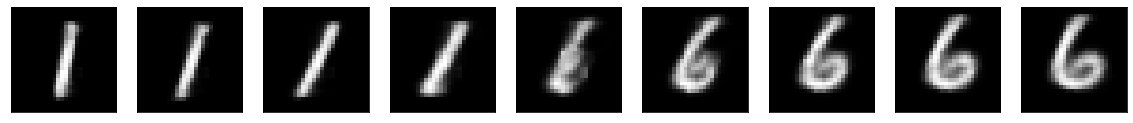

In [26]:
display_image_sequence( 0, 2, 2, 0, 9 )

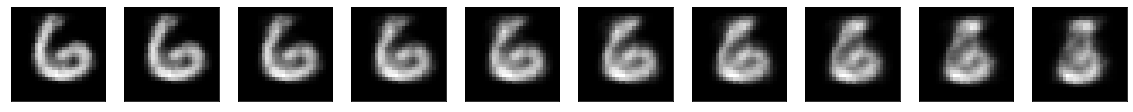

In [27]:
display_image_sequence( 2, -1, 1, 0, 10 )

# Test Model

In [28]:
result = vae.predict( X_test_new )

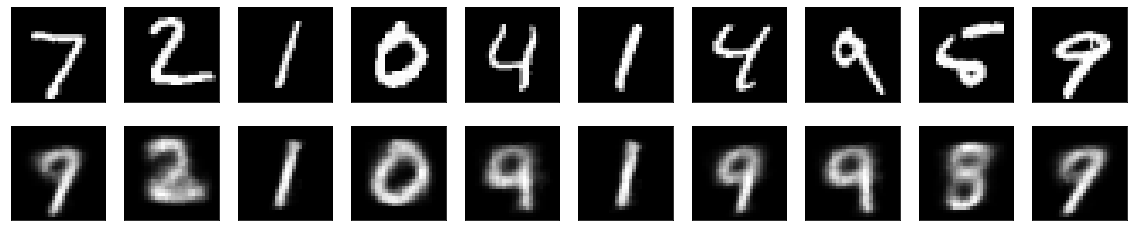

In [30]:
n = 10
plt.figure( figsize = ( 20, 4 ) )
for i in range( n ):
	ax = plt.subplot( 2, n, i + 1 )
	plt.imshow( X_test_new[i].reshape( SIZE, SIZE ) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

	ax = plt.subplot( 2, n, n + i + 1 )
	plt.imshow( result[i].reshape( SIZE, SIZE ) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

plt.savefig( 'Result.png' )
plt.show()
